# GREGOR Functionl enrichment analysis 

GREGOR source codes are downloaded from their [wiki page](https://genome.sph.umich.edu/wiki/GREGOR). Details on the annotations files used can be found in the SuSiE paper (Wang et al 2020 JRSS-B).

## Build container

Since GREGOR is released under UMichgan license, we build a Singularity container `singularity.sif` to run it locally without pushing the image into any container repositories. 

## Run GREGOR

The pipeline running GREGOR analysis is available at https://github.com/cumc/xqtl-pipeline/blob/main/code/enrichment/gregor.ipynb. 

Here is an example analyzing the combined mvSuSiE vs SuSiE signals across 16 traits. We also performed analysis on each of the 16 traits separately. 

In [ ]:
#mvsusie
sos run /home/rf2872/codes/xqtl-pipeline/pipeline/gwas_enrichment.ipynb gregor \
    --index_snp_file /mnt/vast/hpc/csg/rf2872/data/GREGOR/example/mvsusie.crosstrait.index.snps.txt \
    --bed_file_index /mnt/vast/hpc/csg/rf2872/data/GREGOR/example/bed_annotations.bed.file.index \
    -c /home/rf2872/container_ru/gregor.sif 


In [ ]:
#susie
sos run /home/rf2872/codes/xqtl-pipeline/pipeline/gwas_enrichment.ipynb gregor \
    --index_snp_file /mnt/vast/hpc/csg/rf2872/data/GREGOR/example/susie.crosstrait.index.snps.txt \
    --bed_file_index /mnt/vast/hpc/csg/rf2872/data/GREGOR/example/bed_annotations.bed.file.index \
    -c /home/rf2872/container_ru/gregor.sif 

We prepare the commands into multiple scripts for various traits. Here is the `qsub` command to submit multiple bash scripts to run paralelle

In [ ]:
cd ~/data/mvsusie/positive 
for i in job*sh; do qsub $i; done

```
#!/bin/bash
prepare snp list
#for i in *tsv; do cut -f 4 $i |tail -n +2 |sort|uniq |cut -f 1 -d_ > $(basename $i .tsv).index.snps.txt ;done

#generate sperate job command
for file in `realpath *index.snps.txt`; do
    base_name=$(basename "$file" .txt)

    job_script="job_${base_name}.sh"

    cat > "$job_script" <<- EOM
    
#!/bin/sh
#$ -l h_rt=90:00:00
#$ -l h_vmem=16G
#$ -N gregor
#$ -o /mnt/vast/hpc/csg/rf2872/Work/GREGOR/gregor-\$JOB_ID.out
#$ -e /mnt/vast/hpc/csg/rf2872/Work/GREGOR/gregor-\$JOB_ID.err
#$ -j y
#$ -q csg.q
#$ -S /bin/bash

module load Singularity
module load R/4.2.2.10
source ~/.bashrc
export PATH=\$HOME/miniconda3/bin:\$PATH
export SINGULARITY_BIND="/mnt/vast/hpc/csg/:/mnt/vast/hpc/csg/"
export LD_LIBRARY_PATH=\$LD_LIBRARY_PATH:/mnt/mfs/cluster/R-Deb10_Libs

cd /mnt/vast/hpc/csg/rf2872/Work/GREGOR


sos run /mnt/vast/hpc/homes/rf2872/codes/xqtl-pipeline/code/enrichment/gregor.ipynb gregor \
    --index_snp_file $file \
    --bed_file_index /mnt/vast/hpc/csg/rf2872/data/GREGOR/example/bed_annotations.bed.file.index \
    --container /home/rf2872/container_ru/gregor.sif 

EOM

    chmod +x "$job_script"
done

echo "Generated job scripts for all .index.snps.txt; files."
```

## Post Processing and visualization


In [218]:
library(dplyr)
library(readr)
library(stringr)
library(ggplot2)

setwd("~/Work/GREGOR//")


In [ ]:
res_all <- tibble()
for(pheno in c("mvsusie_new", "susie_new_uniq")){
    res <- read_tsv(paste0(pheno, "/StatisticSummaryFile_new.txt")) 
    res$group <- pheno
        # Assuming 'res' is your data frame and has the necessary columns
    for(i in 1:nrow(res)){
        n1 = res$InBed_Index_SNP[i]
        n2 = res$N1_N2[i] - n1
        np = res$Np[i]
        nn = res$Np_Nn[i] - np

        # Construct the contingency matrix
        dat = matrix(c(n1, n2, np - n1, nn - n2), nrow = 2)

        # Perform Fisher's exact test
        test_res = fisher.test(dat, alternative = 'two.sided')

        # Store the results in 'res'
        res$odds[i] <- test_res$estimate
        res$low[i] <- test_res$conf.int[1]
        res$high[i] <- test_res$conf.int[2]
        res$p_fisher[i] <- test_res$p.value
    }

    res$odds <- as.numeric(res$odds)
    res_all <- rbind(res, res_all)
}


In [316]:
res_all$feature <- gsub(".bed","",res_all$Bed_File)
# Assuming res_all is your DataFrame and group is the column of interest
res_all$group[res_all$group == "mvsusie_new"] <- "mvsusie"
res_all$group[res_all$group == "susie_new_uniq"] <- "susie"


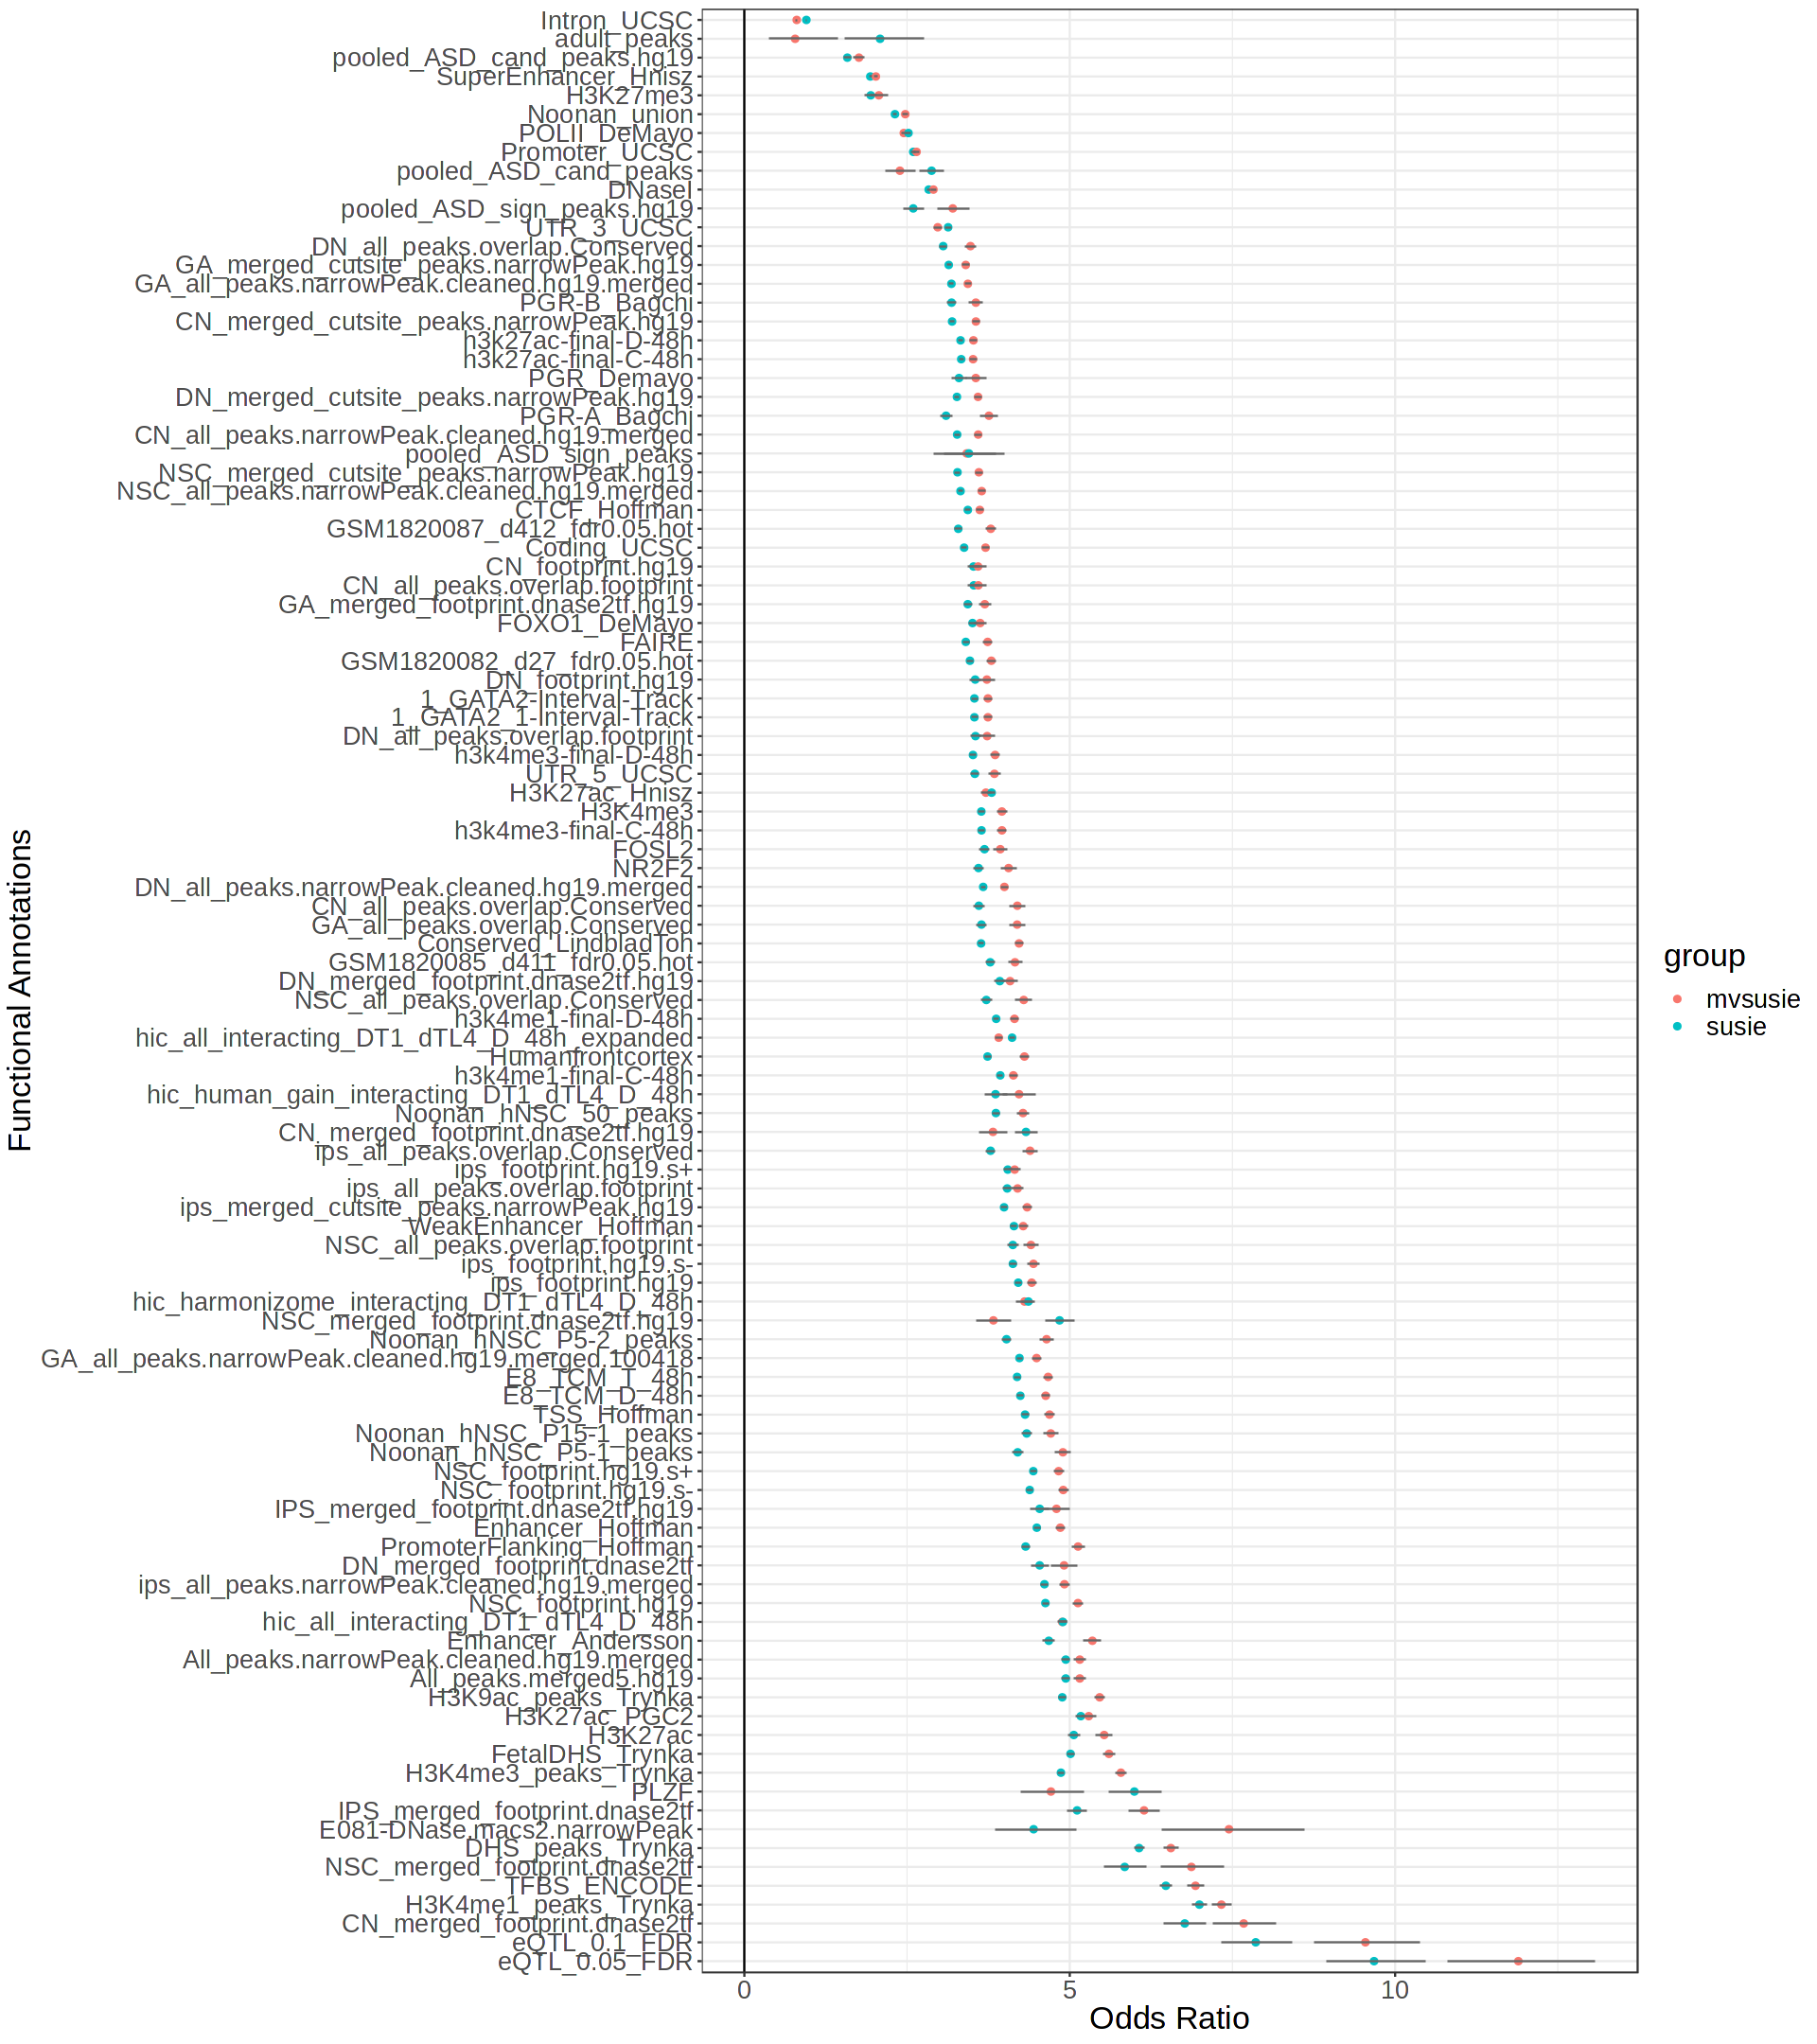

In [390]:
res_all <- res_all %>%filter(!(str_detect(feature,"hg38")))%>%filter(!(PValue >= 1))%>% na.omit 
res_all%>%
    arrange(odds)%>%ggplot()+geom_point(aes(x = odds, y = reorder(feature,-odds), color = group))+
        geom_vline(aes( xintercept = 0 ))+theme_bw()+theme(text = element_text(size = 20))+xlab("Odds Ratio")+
            geom_linerange(aes(xmin = low, xmax= high , y = feature ), color= 'grey40')+ylab("Functional Annotations")

In [391]:
ggsave("/home/rf2872/Work/GREGOR/all_mvsusie_susie.pdf", height = 24, width = 20)

In [10]:
options(repr.plot.width=16, repr.plot.height=18)

### split the plot by category

In [379]:
##ROUGH!!!

a = list("chromatin accessibility histone modification" = c(
    "DNaseI.bed", "FAIRE.bed", 
    "H3K27ac.bed", "H3K27ac_Hnisz.bed", "H3K27ac_PGC2.bed", "H3K27me3.bed", 
    "H3K4me1_peaks_Trynka.bed", "H3K4me3.bed", "H3K4me3_peaks_Trynka.bed", 
    "H3K9ac_peaks_Trynka.bed", 
    "h3k27ac-final-C-48h.bed", "h3k27ac-final-D-48h.bed", 
    "h3k4me1-final-C-48h.bed", "h3k4me1-final-D-48h.bed", 
    "h3k4me3-final-C-48h.bed", "h3k4me3-final-D-48h.bed", 
    "E081-DNase.macs2.narrowPeak.bed"
),
"transcription factor binding sites" = c(
    "TFBS_ENCODE.bed", "FOSL2.bed", "FOXO1_DeMayo.bed", 
    "NR2F2.bed", "PLZF.bed", "POLII_DeMayo.bed", 
    "PGR-A_Bagchi.bed", "PGR-B_Bagchi.bed", "PGR_Demayo.bed"
),
"enhancer promoter regions" = c(
    "Enhancer_Andersson.bed", "Enhancer_Hoffman.bed", 
    "PromoterFlanking_Hoffman.bed", "Promoter_UCSC.bed", "Promoter_UCSC.hg38.bed", 
    "Repressed_Hoffman.bed", "SuperEnhancer_Hnisz.bed", "TSS_Hoffman.bed", 
    "WeakEnhancer_Hoffman.bed", 
    
    "fantomFetalBrainCage.gt10.bed","fantomFetalBrainCage.eq0.bed"
),
"sequencing data peaks" = c(
    "All_peaks.merged5.hg19.bed", "All_peaks.narrowPeak.cleaned.hg19.merged.bed", 
    "CN_all_peaks.narrowPeak.cleaned.hg19.merged.bed", 
    "CN_all_peaks.overlap.Conserved.bed", "CN_all_peaks.overlap.footprint.bed", 
    "CN_footprint.hg19.bed", "CN_merged_cutsite_peaks.narrowPeak.hg19.bed", 
    "CN_merged_footprint.dnase2tf.bed", "CN_merged_footprint.dnase2tf.hg19.bed", 
    "DN_all_peaks.narrowPeak.cleaned.hg19.merged.bed", 
    "DN_footprint.hg19.bed", "DN_merged_cutsite_peaks.narrowPeak.hg19.bed", 
    "DN_merged_footprint.dnase2tf.bed", "DN_merged_footprint.dnase2tf.hg19.bed", 
    "GA_all_peaks.narrowPeak.cleaned.hg19.merged.100418.bed", 
    "GA_all_peaks.narrowPeak.cleaned.hg19.merged.bed", "GA_all_peaks.overlap.Conserved.bed", 
    "GA_merged_cutsite_peaks.narrowPeak.hg19.bed", "GA_merged_footprint.dnase2tf.hg19.bed", 
    "NSC_all_peaks.narrowPeak.cleaned.hg19.merged.bed", "NSC_all_peaks.overlap.Conserved.bed", 
    "NSC_all_peaks.overlap.footprint.bed", "NSC_footprint.hg19.bed", 
    "NSC_footprint.hg19.s+.bed", "NSC_footprint.hg19.s-.bed", 
    "NSC_merged_cutsite_peaks.narrowPeak.hg19.bed", "NSC_merged_footprint.dnase2tf.bed", 
    "NSC_merged_footprint.dnase2tf.hg19.bed", "ips_all_peaks.narrowPeak.cleaned.hg19.merged.bed", 
    "ips_all_peaks.overlap.Conserved.bed", "ips_all_peaks.overlap.footprint.bed", 
    "ips_footprint.hg19.bed", "ips_footprint.hg19.s+.bed", "ips_footprint.hg19.s-.bed", 
    "ips_merged_cutsite_peaks.narrowPeak.hg19.bed", "E8_TCM_D_48h.bed", 
    "E8_TCM_T_48h.bed", "GSM1820082_d27_fdr0.05.hot.bed", "GSM1820085_d411_fdr0.05.hot.bed", 
    "GSM1820087_d412_fdr0.05.hot.bed", "adult_peaks.bed", "adult_peaks.hg38.bed", 
    "pooled_ASD_cand_peaks.bed", "pooled_ASD_cand_peaks.hg19.bed", 
    "pooled_ASD_sign_peaks.bed", "pooled_ASD_sign_peaks.hg19.bed"
),

"conserved regions footprints" = c(
    "DN_all_peaks.overlap.footprint.bed", 
    "Conserved_LindbladToh.bed", "CN_footprint.hg19.bed", 
    "DN_all_peaks.overlap.Conserved.bed", "DN_footprint.hg19.bed", 
    "CN8_hg38.cleaned.hg19.merged.bed", "FetalDHS_Trynka.bed", 
    "Humanfrontcortex.bed", "Humanfrontcortex.hg38.bed", 
    "IPS_merged_footprint.dnase2tf.bed", "IPS_merged_footprint.dnase2tf.hg19.bed", 
    "hic_all_interacting_DT1_dTL4_D_48h.bed", "hic_all_interacting_DT1_dTL4_D_48h_expanded.bed", 
    "hic_harmonizome_interacting_DT1_dTL4_D_48h.bed", "hic_human_gain_interacting_DT1_dTL4_D_48h.bed", 
    "in.sorted.bed"
),


# eQTLs and LD Data
"eqtls data" = c(
    "eQTL_0.05_FDR.bed", "eQTL_0.1_FDR.bed", 
    "eur_ld_breakpoints.bed"
),

# Genomic Structural Elements
"genomic structural elements" = c("Coding_UCSC.bed",
    "Intron_UCSC.bed", "UTR_3_UCSC.bed", "UTR_5_UCSC.bed"
),


"specific research experimentally_derived_data" = c(
    "1_GATA2-Interval-Track.bed", "1_GATA2_1-Interval-Track.bed", 
    "Noonan_hNSC_50_peaks.bed", "Noonan_hNSC_P15-1_peaks.bed", 
    "Noonan_hNSC_P5-1_peaks.bed", "Noonan_hNSC_P5-2_peaks.bed", 
    "Noonan_union.bed"
)
)

In [380]:
mvs <- res_all %>% filter(group == 'mvsusie')
s <- res_all%>%filter(group == 'susie')

mvs$diff <- mvs$odds - s$odds
top_diff <- mvs %>% arrange(desc(diff)) %>% select(Bed_File) %>% .[1:10,]

In [381]:
label_anno <- unique(c(top_diff$Bed_File, transcription_factor_binding_sites, enhancer_promoter_regions, eqtls_ld_data, genomic_structural_elements))

In [382]:
res_all_p = left_join(res_all, stack(a), by = c("Bed_File" = "values"))

Warning message in left_join(res_all, stack(a), by = c(Bed_File = "values")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 8 of `x` matches multiple rows in `y`.
ℹ Row 108 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [384]:
plot_df <- res_all_p %>% filter(Bed_File %in% label_anno) %>% arrange(odds) %>% na.omit
plot_df$Bed_File <- as.factor(plot_df$Bed_File)

In [385]:
plot_df$feature <- factor(plot_df$feature, levels = unique(plot_df$feature))


In [386]:
# Calculate the difference between averages
#diff <- average_p_sqtl - average_u_sqtl

top_annotations <- head(plot_df[order(-plot_df$odds), ]%>%distinct(feature, .keep_all = T), 5)
top_annotations
    # Assuming your data is in a dataframe called `data`
# Replace 'data' with the actual name of your dataframe
    
    diff <- plot_df[plot_df$group == "mvsusie",]
plot_df_mvs <- plot_df[plot_df$group == "mvsusie",]
plot_df_s <- plot_df[plot_df$group == "susie",]

diff$diff_value <- abs(plot_df_mvs$odds - plot_df_s$odds)

diff_annotation <- head(diff[order(-diff$diff_value), ], 5)
diff_annotation

all_top_annotations <- cbind(top_annotations,diff_annotation[,-9])

Bed_File,InBed_Index_SNP,ExpectNum_of_InBed_SNP,PValue,N1_N2,Np,Np_Nn,group,odds,low,high,p_fisher,feature,ind
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
eQTL_0.05_FDR.bed,482,266.2349,6.118929e-40,4770,68356,7254522,mvsusie,11.893872,10.798594,13.074881,6.634215e-319,eQTL_0.05_FDR,eqtls data
eQTL_0.1_FDR.bed,593,348.4736,3.319382e-39,7177,68356,7254522,mvsusie,9.543575,8.756405,10.383576,0.000000e+00,eQTL_0.1_FDR,eqtls data
TFBS_ENCODE.bed,54189,48330.5675,0.000000e+00,2609381,68356,7254522,mvsusie,6.932357,6.805201,7.062022,0.000000e+00,TFBS_ENCODE,transcription factor binding sites
PLZF.bed,949,525.7084,1.136989e-80,12108,125587,8919803,susie,5.992817,5.602292,6.406233,0.000000e+00,PLZF,transcription factor binding sites
Enhancer_Andersson.bed,6760,4448.3492,6.623321e-293,151249,68356,7254522,mvsusie,5.347958,5.211865,5.488273,0.000000e+00,Enhancer_Andersson,enhancer promoter regions


Bed_File,InBed_Index_SNP,ExpectNum_of_InBed_SNP,PValue,N1_N2,Np,Np_Nn,group,odds,low,high,p_fisher,feature,ind,diff_value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
eQTL_0.05_FDR.bed,482,266.2349,6.118929e-40,4770,68356,7254522,mvsusie,11.893872,10.798594,13.074881,6.634215e-319,eQTL_0.05_FDR,eqtls data,2.2173822
eQTL_0.1_FDR.bed,593,348.4736,3.319382e-39,7177,68356,7254522,mvsusie,9.543575,8.756405,10.383576,0.000000e+00,eQTL_0.1_FDR,eqtls data,1.6856332
Enhancer_Andersson.bed,6760,4448.3492,6.623321e-293,151249,68356,7254522,mvsusie,5.347958,5.211865,5.488273,0.000000e+00,Enhancer_Andersson,enhancer promoter regions,0.6448595
TFBS_ENCODE.bed,54189,48330.5675,0.000000e+00,2609381,68356,7254522,mvsusie,6.932357,6.805201,7.062022,0.000000e+00,TFBS_ENCODE,transcription factor binding sites,0.4555359
PromoterFlanking_Hoffman.bed,12072,7507.3634,0.000000e+00,300570,68356,7254522,mvsusie,5.128066,5.026601,5.232011,0.000000e+00,PromoterFlanking_Hoffman,enhancer promoter regions,0.4494865


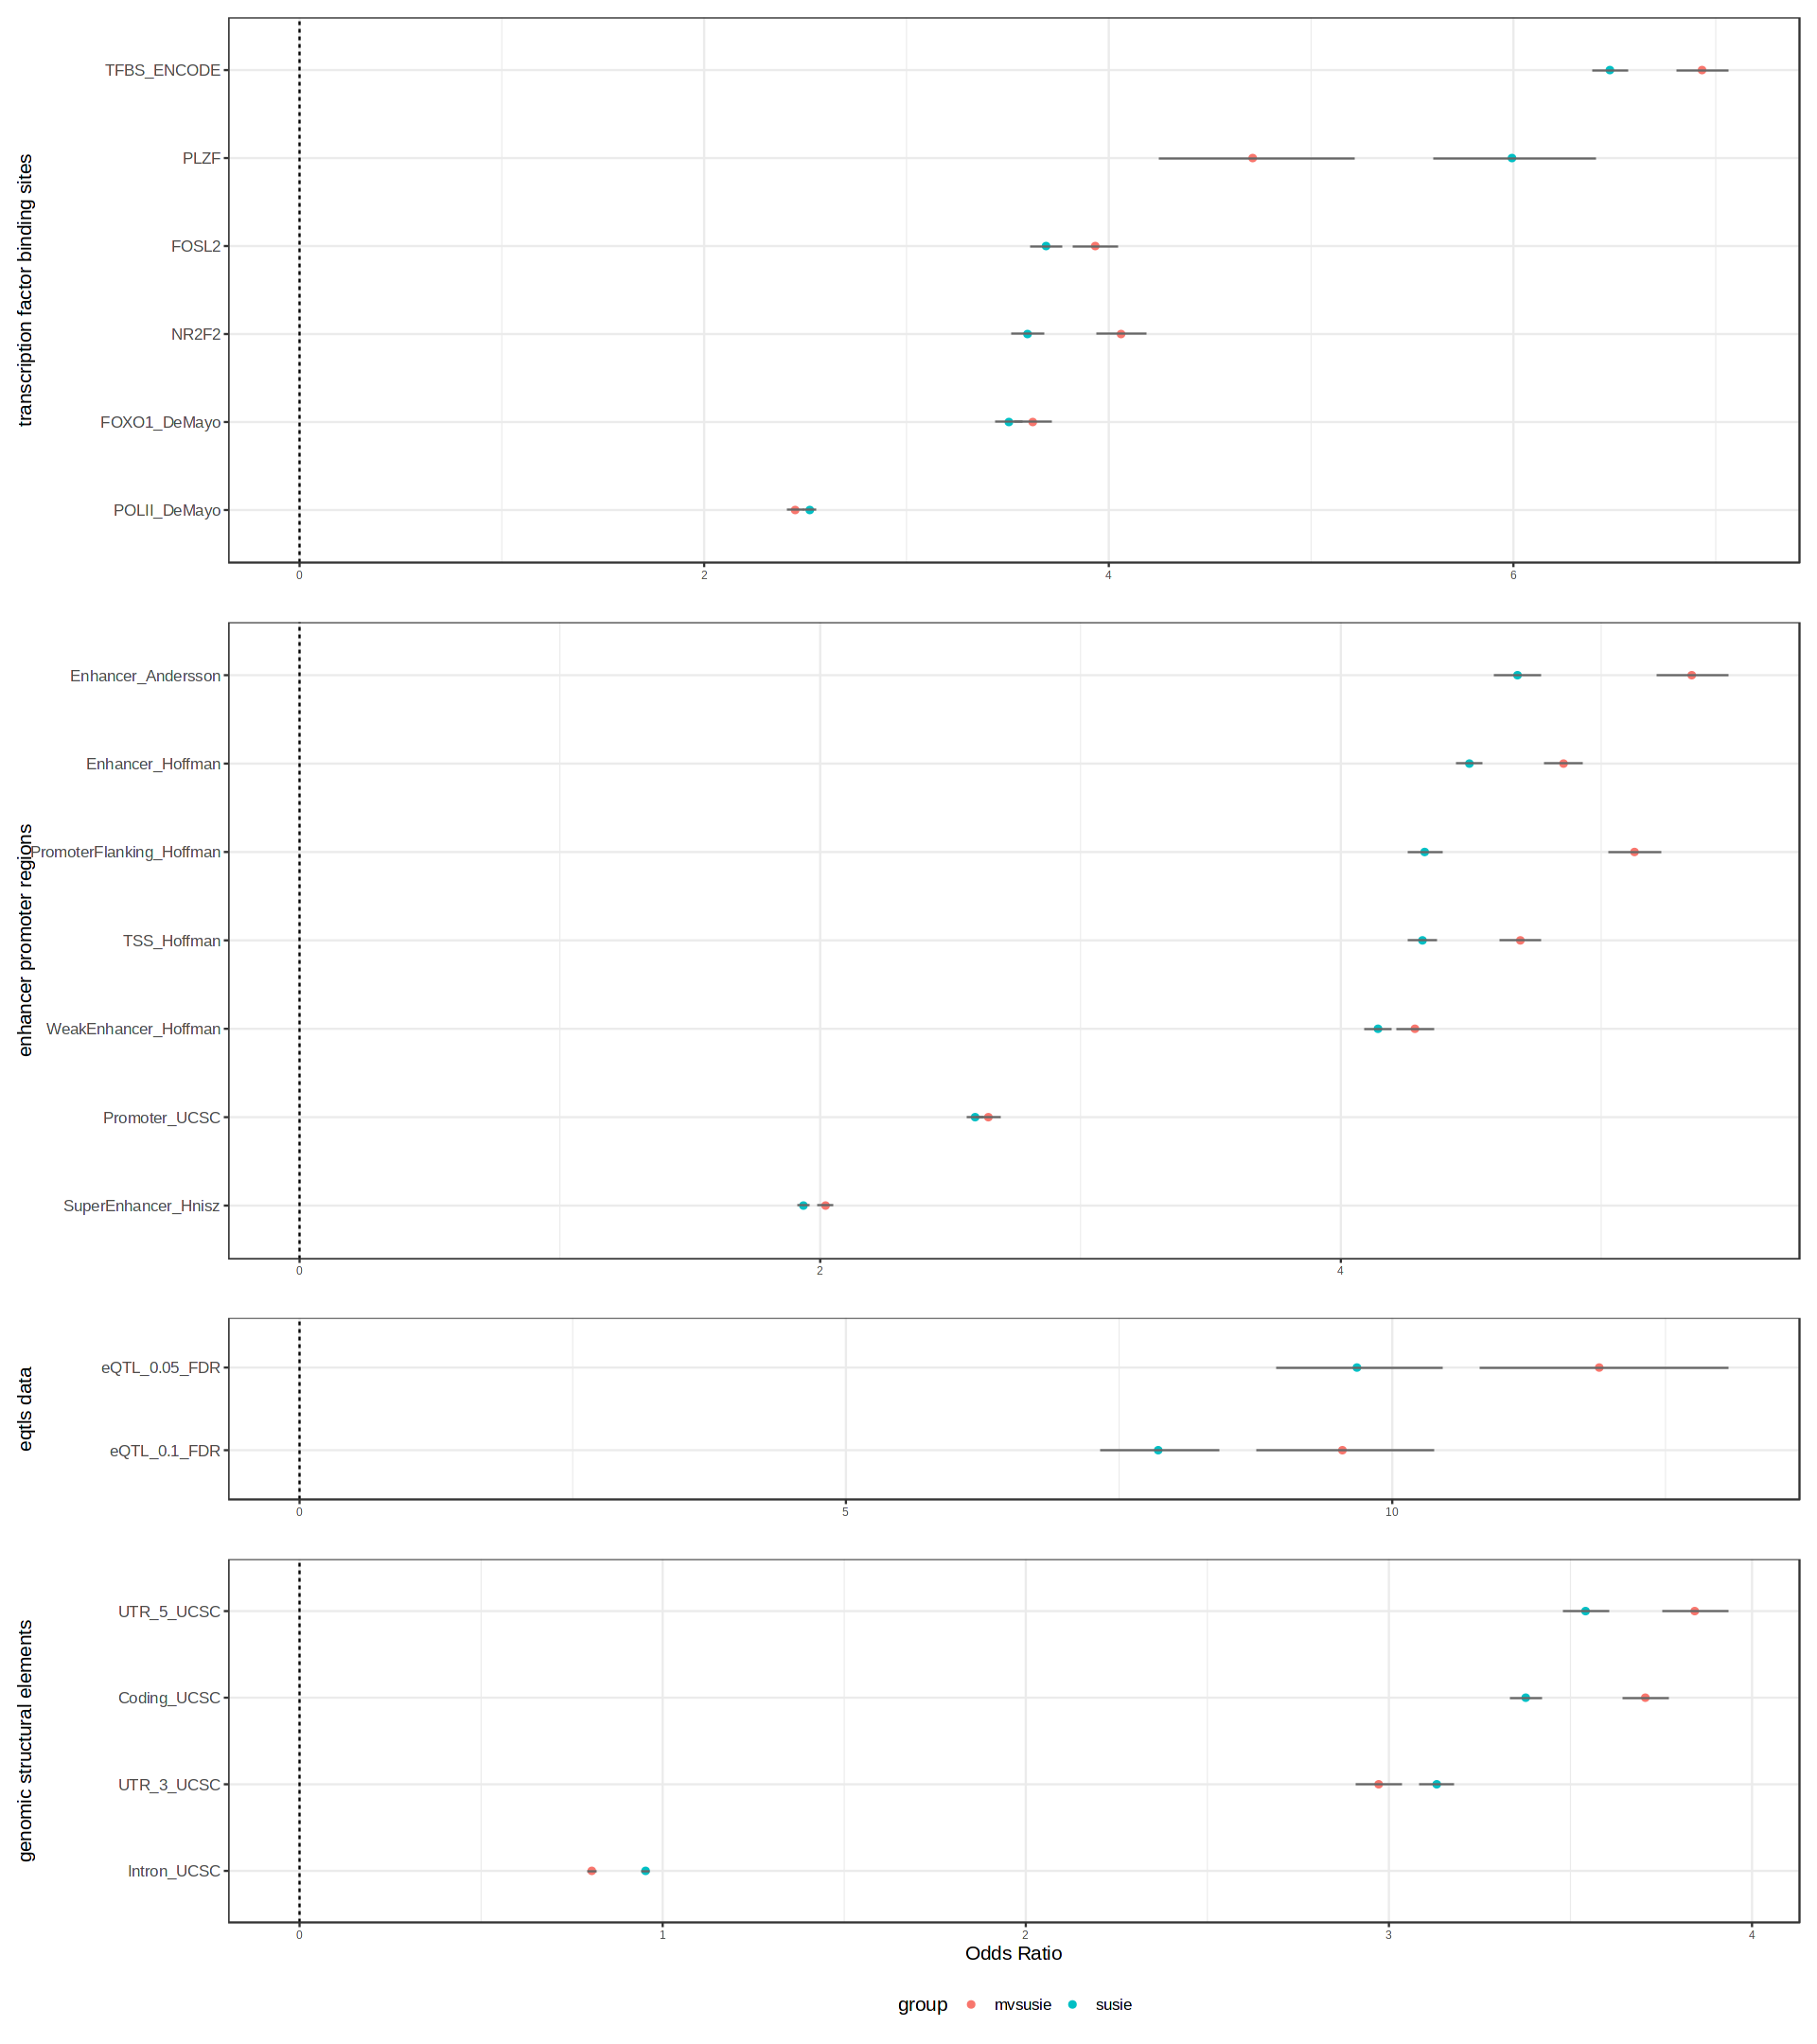

In [387]:
#seperate label top2 in each group
library(ggplot2)
library(dplyr)
library(patchwork)
library(ggrepel)
library(purrr)
plots <- plot_df %>%
  split(.$ind, drop = T) %>%
  imap(function(data_subset, ind_name) {
     # Determine the top 2 annotations for each ind
    top_annotations_tmp <- data_subset[data_subset$feature %in% top_annotations$feature,]%>%distinct(feature, .keep_all = T)
    top_annotations_tmp$anno_type <- "top"
    diff_annotations_tmp <- data_subset[data_subset$feature %in% diff_annotation$feature,]%>%distinct(feature, .keep_all = T)
    diff_annotations_tmp$anno_type <- "diff"
    annotations <- rbind(top_annotations_tmp, diff_annotations_tmp) %>% distinct(Bed_File,.keep_all = T)
    
    # Create the plot
    p <- ggplot(data_subset, aes(x = odds, y = factor(feature), color = group)) +  geom_point() +
      geom_vline(xintercept = 0, linetype = "dashed") +
      theme_bw() +
      xlab("") +
      ylab(unique(data_subset$ind)) +
      theme(
        text = element_text(size = 12),
        #axis.text.y = element_blank(),
        #axis.ticks.y = element_blank(),
        axis.text.x = element_text(size = 7),
        strip.text = element_text(size = 12),
        legend.position = "none"
      ) +
#      scale_color_brewer(palette = "Set2") +
      guides(size = FALSE)+
            geom_linerange(aes(xmin = low, xmax= high , y = feature ), color= 'grey40')
    
    # Add the ind as an annotation to the plot
    #p <- p + annotate("text", x = Inf, y = Inf, label = ind_name, hjust = 1.1, vjust = 1.1, size = 5, color = "black")
    
    # Add repelling labels for the top 2 annotations with black color
    #p <- p + geom_text_repel(
#       aes(label = feature),
#       data = annotations,
#       box.padding = 0.35,    # Adjust box padding as necessary
#       point.padding = 0.5,   # Adjust point padding as necessary
#       size = 3.5,
#       color = "black"
#     )
    
    # Return the plot
    p
  })


# Keep the legend only on the last plot
plots[[length(plots)]] <- plots[[length(plots)]] + theme(legend.position = "bottom")

# Determine the relative heights of the panels based on the number of annotations in each subset
panel_heights <- lapply(plots, function(p) length(unique(p$data$feature)))
total_height <- sum(unlist(panel_heights))
panel_heights <- lapply(panel_heights, function(h) h / total_height)

# Combine the plots with custom heights using patchwork
plot_layout <- wrap_plots(plots, heights = panel_heights) +
      xlab("Odds Ratio") 
# Print the combined plot
plot_layout


In [388]:
ggsave("/home/rf2872/Work/GREGOR/all_mvsusie_susie_cases.pdf", height = 10, width = 8)

For the detailed information about the annotations, please see [LDSC baseline paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4626285/)

transcription factor related:

- TFBS: Transcription factor binding site. A specific region of DNA where transcription factors bind to control the transcription of genes.
- PLZF: Promyelocytic leukemia zinc finger protein. This protein is a glucocorticoid- and progesterone-induced transcription factor known for its role in various cellular processes, including gene expression regulation.
- FOSL2: FOS Like 2, an AP-1 Transcription Factor Subunit. FOSL2 is implicated in diseases such as Breast Cancer, highlighting its significance in cell cycle regulation and oncogenesis.
- NR2F2: This gene encodes a member of the steroid thyroid hormone superfamily of nuclear receptors. The protein encoded by NR2F2 functions as a ligand-inducible transcription factor and plays a critical role in regulating the expression of various genes.
- FOXO1_DeMayo (forkhead box O1A): Identified as a transcriptional coregulator of the progesterone receptor (PR) during decidualization. In vitro studies suggest a direct physical interaction between PR, providing insights into the regulatory mechanisms of gene expression,[ref](https://academic.oup.com/mend/article/29/3/421/2556207).
- PolII_DeMayo (RNA polymerase II): Essential for gene transcription, RNA polymerase II facilitates the transcription of DNA to mRNA. It plays a pivotal role in cellular signaling by modulating the rate of transcriptional pause release, thereby influencing gene expression in response to various stimuli,[ref](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6338652/).    
    **Removing RNA polymerase II from this category could make classification more logically tight and consistent, and the category would be more focused on factors that are directly involved in or influence the transcriptional regulation of specific genes.**

enhancer and promoter: 
- [Andersson](https://www.nature.com/articles/nature12787): Data from FANTOM5, including regular enhancer and promoter, published in 2014. 
- [Hoffman](https://www.cell.com/molecular-cell/pdf/S1097-2765(21)01140-0.pdf): The CTCF, promoter flanking, transcribed, transcription start site, strong enhancer, and weak enhancer categories are each a union over the six cell lines; the repressed category is an intersection over the six cell lines.
- [Hnisz](https://www.sciencedirect.com/science/article/pii/S0092867413012270?via%3Dihub): Super-enhancers are large clusters of transcriptional enhancers that drive expression of genes that define cell identity.
- [USCS](https://pubmed.ncbi.nlm.nih.gov/12045153/) 

eQTL data: 
- have not found resource yet

genomic structual elements: 
- Coding, 3′-UTR, 5′-UTR, promoter, and intron annotations from the RefSeq gene model were obtained from UCSC and post-processed by [Gusev et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4225595/)